1. How to make it available for marking? (eg is slack they say make TAs collaborators or make it public)
2. distnace matrix h as eucledian distances squared (good in code, check in proofs)

## 1. Import Packages

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import euclidean_distances
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.manifold import MDS
import scipy.linalg as la
import pandas as pd
import seaborn as sns

## 2. Functions and helpers

In [2]:
def is_symmetric(A, rtol=1e-05, atol=1e-08):
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

In [3]:
def data_centering(Y_uncentered, tol=10e-10):
    """ Center the data matrix, that is, subtract the mean of each feature space from the features of each
    data point/vector. Pre-requisite for PCA and MDS.
    
    Parameters
    ----------
    Y_uncentered : numpy.ndarray
        The uncentered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
        
    Returns
    -------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
    """
    # Data centering (subtract mean of each column/feature from each entry in that column).
    # Use Numpy broadcasting.
    Y = Y_uncentered - Y_uncentered.mean(axis=0).astype(np.float64)
    
    assert all(Y.mean(axis=0) < tol), "Data centering was unsuccesful."
    
    return Y

## 2. Read data

In [4]:
# Read data frame with no header.
df = pd.read_csv("zoo.data", header=None)

# Name columns (no header previously).
df.columns = ["animal name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator",
             "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]

# Show some rows.
print(df.shape)
df.head(20)

(101, 18)


animal name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0     aardvark     1         0     0     1         0        0         1   
1     antelope     1         0     0     1         0        0         0   
2         bass     0         0     1     0         0        1         1   
3         bear     1         0     0     1         0        0         1   
4         boar     1         0     0     1         0        0         1   
5      buffalo     1         0     0     1         0        0         0   
6         calf     1         0     0     1         0        0         0   
7         carp     0         0     1     0         0        1         0   
8      catfish     0         0     1     0         0        1         1   
9         cavy     1         0     0     1         0        0         0   
10     cheetah     1         0     0     1         0        0         1   
11     chicken     0         1     1     0         1        0         0   
12        chub     0         0     1     0         0        1         1   
13        clam     0         0     1     0         0        0         1   
14        crab     0         0     1     0         0        1         1   
15    crayfish     0         0     1     0         0        1         1   
16        crow     0         1     1     0         1        0         1   
17        deer     1         0     0     1         0        0         0   
18     dogfish     0         0     1     0         0        1         1   
19     dolphin     0         0     0     1         0        1         1   

    toothed  backbone  breathes  venomous  fins  legs  tail  domestic  \
0         1         1         1         0     0     4     0         0   
1         1         1         1         0     0     4     1         0   
2         1         1         0         0     1     0     1         0   
3         1         1         1         0     0     4     0         0   
4         1         1         1         0     0     4     1         0   
5         1         1         1         0     0     4     1         0   
6         1         1         1         0     0     4     1         1   
7         1         1         0         0     1     0     1         1   
8         1         1         0         0     1     0     1         0   
9         1         1         1         0     0     4     0         1   
10        1         1         1         0     0     4     1         0   
11        0         1         1         0     0     2     1         1   
12        1         1         0         0     1     0     1         0   
13        0         0         0         0     0     0     0         0   
14        0         0         0         0     0     4     0         0   
15        0         0         0         0     0     6     0         0   
16        0         1         1         0     0     2     1         0   
17        1         1         1         0     0     4     1         0   
18        1         1         0         0     1     0     1         0   
19        1         1         1         0     1     0     1         0   

    catsize  type  
0         1     1  
1         1     1  
2         0     4  
3         1     1  
4         1     1  
5         1     1  
6         1     1  
7         0     4  
8         0     4  
9         0     1  
10        1     1  
11        0     2  
12        0     4  
13        0     7  
14        0     7  
15        0     7  
16        0     2  
17        1     1  
18        1     4  
19        1     1

## 3. EDA

/home/mark/anaconda3/envs/ml_adv_ass_1_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='type', ylabel='count'>

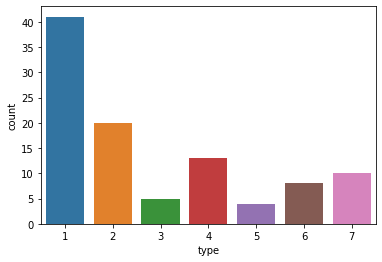

In [5]:
# Show observation frequencies in classes.
sns.countplot(df['type'],label="Count")

Text(0.5, 1.05, 'Correlation of Zoo Features')

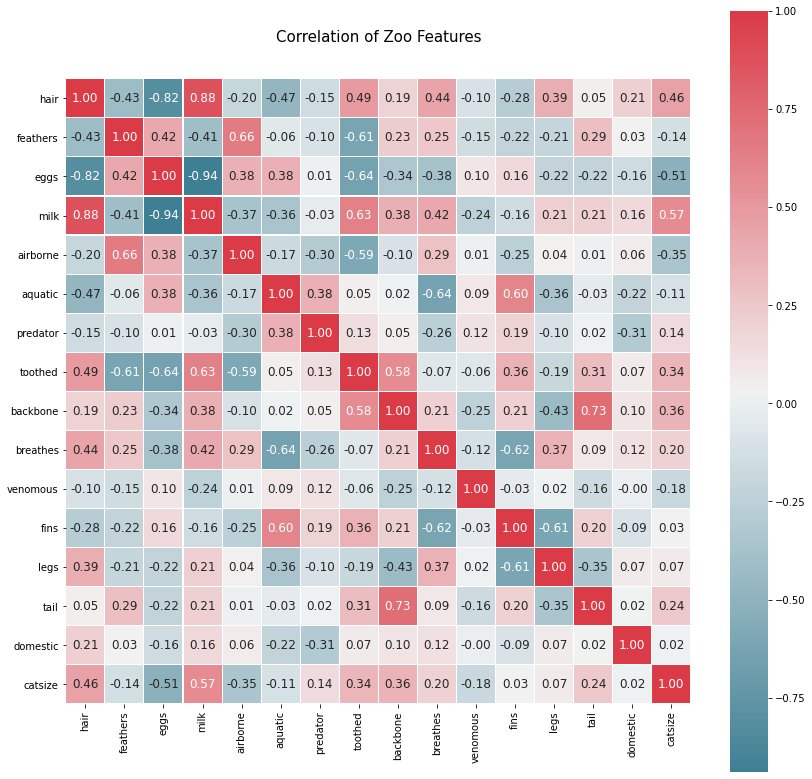

In [6]:
# Show correlations. E.g.: hair - milk is high = mammals have hair and milk
corr = df.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Zoo Features', y=1.05, size=15) 

## 4. Dimensionality Reduction

### 4.1 Principal Component Analysis (PCA)

In [7]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
print(Y_uncentered.shape)
print(Y_uncentered)

(101, 16)
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


In [8]:
# Data centering (subtract mean of each columns/features from each entry in that column)
Y = data_centering(Y_uncentered=Y_uncentered)

In [9]:
# Do PCA on centered data and embed data into 2 dimensions.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Y)

In [10]:
print(pca.explained_variance_ratio_)

[0.62561548 0.14496905]


In [11]:
df_pca = pd.DataFrame({'pc1': X_pca[:, 0], 'pc2': X_pca[:, 1], 
                       'animal name': df['animal name'], 'type': df['type']})
print(df_pca.shape)
df_pca.head(20)

(101, 4)


pc1       pc2 animal name  type
0   1.351029 -1.058533    aardvark     1
1   1.306634 -1.208344    antelope     1
2  -3.131655  0.252200        bass     4
3   1.351029 -1.058533        bear     1
4   1.277296 -1.225750        boar     1
5   1.306634 -1.208344     buffalo     1
6   1.321069 -1.257643        calf     1
7  -3.087882  0.220307        carp     4
8  -3.131655  0.252200     catfish     4
9   1.373629 -0.771044        cavy     1
10  1.277296 -1.225750     cheetah     1
11 -0.855604  0.960287     chicken     2
12 -3.131655  0.252200        chub     4
13 -2.730703  0.940054        clam     7
14  1.046634  1.394325        crab     7
15  2.982256  1.558441    crayfish     7
16 -0.899376  0.992180        crow     2
17  1.306634 -1.208344        deer     1
18 -3.110483 -0.067182     dogfish     4
19 -2.906024 -1.070470     dolphin     1

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

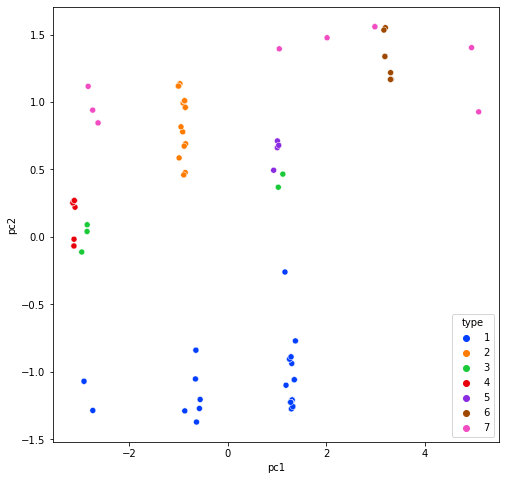

In [12]:
# Generate figure.
fig = plt.figure(figsize=(8,8))

sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="type", palette="bright")

### 2.2 Multi-Dimensional Scaling (MDS)

In [13]:
def distance_marix_from_data(Y):
    """ Derive the pairwise distance matrix from the data matrix.
    
    Parameters
    ----------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
        
    Returns
    -------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered.
    """
    D = euclidean_distances(Y)
    D = np.power(D, 2)
    
    assert is_symmetric(A=D), "The distance matrix is D non-symmetric."
    
    return D

In [14]:
def double_centering(D):
    """ Double centering trick to derive a similarity matrix from a pairwise distance matrix for 
    inputting to MDS.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered.
        
    Returns
    -------
    S : numpy.ndarray
        Gram matrix or pairwise similarity matrix (symmetric, real). The input to the MDS algorithm.
    """
    # Derive the Gram matrix of the data matrix from the distance matrix D. Use Numpy broadcasting to: 
    # (1) subtract from each entry of D the mean of the corresponding row
    # (2) subtract the mean of the corresponding column
    # (3) add back the mean of all entries
    S = -0.5 * (D - D.mean(axis=1).reshape(D.shape[0],1) - D.mean(axis=0).reshape(1,D.shape[0]) + D.mean())
    
    return S

In [15]:
def mds_from_distance_matrix(D):
    """ Multidimensional scaling (MDS) algorithm (classical MDS) with the pairwise distance matrix of the
    data matrix as input.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered.
        
    Returns
    -------
    X : numpy.ndarray
        Embedding of the data matrix from which the pairwise distance matrix D was derived.
        The shape of X is (J, N) where J is the dimension of the embedding.
        MDS is based on the eigendecomposition of the Gram matrix S (symmetric, real = real 
        eigenvalues and eigenvectors). Due to numerical stability issues, some eigenvalues close 
        to zero might end up being tiny negative numbers. As a result, X is the J dimensional representation/
        embedding of the data matrix where J corresponds to the number of strictily positive
        eigenvalues (J is lower than or equal to N).
    """
    # Get the Gram matrix.
    S = double_centering(D=D)
    
    # Eigendecomposition of S. Use the numpy.linalg.eigh to return the eigenvalues and 
    # eigenvectors of a complex Hermitian (conjugate symmetric) or a real symmetric matrix. 
    # Eigenvalues are in a 1-D matrix, eigenvectors are in a 2-D matrix of which each column is 
    # eigenvector at column index idx that corresponds to the eigenvalue at index idx among the 
    # eigenvalues.
    eigenvalues, eigenvectors = np.linalg.eigh(S)

    # Make sure that the eigenvalues and the eigenvectors are sorted in descending order based on the
    # eigenvalues.
    idx_descending   = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx_descending]
    eigenvectors = eigenvectors[:,idx_descending]
    
    # Only use the J positive eigenvalues and their corresponding eigenvectors to embed the data.                  
    idx_positive, = np.where(eigenvalues > 0)
    
    # Eigendecomposition with only the positive eigenvalues and their correspoinding eigenvectors.
    L  = np.diag(np.sqrt(eigenvalues[idx_positive]))
    U  = eigenvectors[:,idx_positive]
    
    # J dimensional embedding of the data matrix. Shape is (J, N). The best dimensions are at lower row indices. 
    X  = np.matmul(U, L)
    
    return X, eigenvalues

In [16]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
print(Y_uncentered.shape)
print(Y_uncentered)

(101, 16)
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


In [17]:
Y = data_centering(Y_uncentered=Y_uncentered)

In [18]:
D = distance_marix_from_data(Y=Y)

In [19]:
X_mds, eigenvalues = mds_from_distance_matrix(D=D)

In [20]:
df_mds = pd.DataFrame({'dim1': X_mds[:, 0], 'dim2': X_mds[:, 1], 
                       'animal name': df['animal name'], 'type': df['type']})
print(df_mds.shape)
df_mds.head(90)

(101, 4)


dim1      dim2 animal name  type
0  -1.351029 -1.058533    aardvark     1
1  -1.306634 -1.208344    antelope     1
2   3.131655  0.252200        bass     4
3  -1.351029 -1.058533        bear     1
4  -1.277296 -1.225750        boar     1
..       ...       ...         ...   ...
85 -2.014445  1.476383    starfish     7
86  3.108244 -0.017053    stingray     4
87  0.942773  0.816241        swan     2
88 -3.185266  1.337733     termite     6
89 -1.036031  0.678978        toad     5

[90 rows x 4 columns]

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

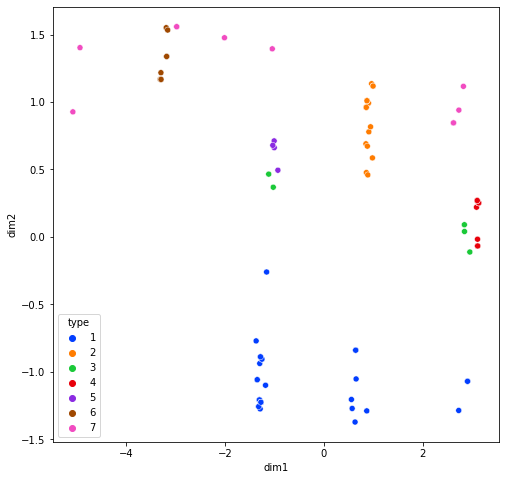

In [21]:
# Generate figure.
fig = plt.figure(figsize=(8,8))

sns.scatterplot(data=df_mds, x="dim1", y="dim2", hue="type", palette="bright")

## 3. Isomap

In [22]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
print(Y_uncentered.shape)
print(Y_uncentered)

(101, 16)
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


In [ ]:
data centering?

In [30]:
D = euclidean_distances(Y_uncentered)

In [32]:
print(np.array_str(D, precision=4, suppress_small=True))

[[0.     1.4142 4.899  ... 1.     4.7958 3.6056]
 [1.4142 0.     4.899  ... 1.     4.7958 3.3166]
 [4.899  4.899  0.     ... 4.7958 2.6458 3.3166]
 ...
 [1.     1.     4.7958 ... 0.     4.899  3.4641]
 [4.7958 4.7958 2.6458 ... 4.899  0.     2.8284]
 [3.6056 3.3166 3.3166 ... 3.4641 2.8284 0.    ]]


In [195]:
k = 50
k_seq = [k for k in range(k+1)]

D_copy = D.copy()

for idx, row in enumerate(D_copy):
    idx = np.argpartition(row, k_seq)
    #print(idx)
    #print(row[idx[:k+1]])
    #print(np.max(row[idx[:k+1]]) < row)
    
    row[np.max(row[idx[:k+1]]) < row] = 0
    
#print("Eliminated")
#print(A)

G = graph_shortest_path(D_copy, method="FW")

In [196]:
print(np.array_str(G, precision=4, suppress_small=True))

[[0.     1.4142 6.3166 ... 1.     6.1451 4.7308]
 [1.4142 0.     6.3166 ... 1.     5.8284 3.3166]
 [5.6458 5.4641 0.     ... 5.4495 2.6458 3.3166]
 ...
 [1.     1.     6.1623 ... 0.     5.9907 4.3166]
 [5.3983 5.3166 2.6458 ... 5.5527 0.     2.8284]
 [4.7308 3.3166 3.3166 ... 4.3166 2.8284 0.    ]]


In [197]:
X_isomap, eigenvaues_isomap = mds_from_distance_matrix(D=G)

In [206]:
df_isomap = pd.DataFrame({'dim1': X_isomap[:, 0], 'dim2': X_isomap[:, 1], 
                          'animal name': df['animal name'], 'type': df['type']})
print(df_isomap.shape)
df_isomap.head(90)

(101, 4)


dim1      dim2 animal name  type
0  -0.790170  0.469133    aardvark     1
1  -0.698389  0.503481    antelope     1
2   1.325522 -0.120482        bass     4
3  -0.790517  0.468595        bear     1
4  -0.709128  0.462970        boar     1
..       ...       ...         ...   ...
85 -0.814091 -0.869274    starfish     7
86  1.254206 -0.064191    stingray     4
87  0.609669 -0.276772        swan     2
88 -1.148409 -0.860922     termite     6
89 -0.553580 -0.396535        toad     5

[90 rows x 4 columns]

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

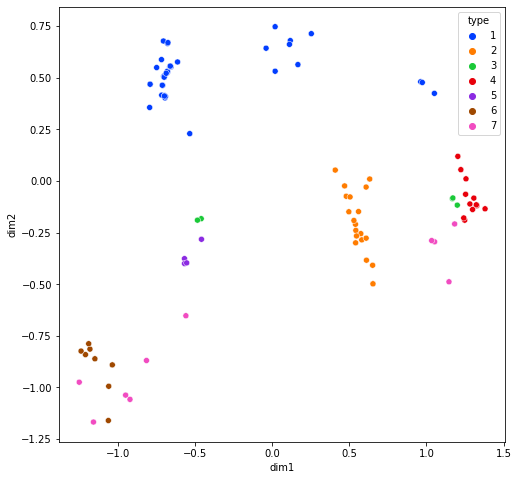

In [207]:
# Generate figure.
fig = plt.figure(figsize=(8,8))

sns.scatterplot(data=df_isomap, x="dim1", y="dim2", hue="type", palette="bright")

In [135]:
k = 2
k_seq = [k for k in range(k+1)]

A = np.array([[0,1,4,2,6], 
              [1,0,3,2,11], 
              [4,3,0,1,3],
              [2,2,1,0,5],
              [6,11,3,5,0]])
print(A)
print(is_symmetric(A))

print(k_seq)
idx = np.argpartition(A, k_seq)
print(idx)

B = np.zeros(A.shape)

for idx, row in enumerate(A):
    idx = np.argpartition(row, k_seq)
    #print(idx)
    #print(row[idx[:k+1]])
    print(np.max(row[idx[:k+1]]) < row)
    
    row[np.max(row[idx[:k+1]]) < row] = 0
    
print("Eliminated")
print(A)

G = graph_shortest_path(A, method="FW")
print("Graph")
print(G)

[[ 0  1  4  2  6]
 [ 1  0  3  2 11]
 [ 4  3  0  1  3]
 [ 2  2  1  0  5]
 [ 6 11  3  5  0]]
True
[0, 1, 2]
[[0 1 3 2 4]
 [1 0 3 2 4]
 [2 3 1 0 4]
 [3 2 1 0 4]
 [4 2 3 1 0]]
[False False  True False  True]
[False False  True False  True]
[ True False False False False]
[False False False False  True]
[ True  True False False False]
Eliminated
[[0 1 0 2 0]
 [1 0 0 2 0]
 [0 3 0 1 3]
 [2 2 1 0 0]
 [0 0 3 5 0]]
Graph
[[0. 1. 3. 2. 6.]
 [1. 0. 3. 2. 6.]
 [3. 3. 0. 1. 3.]
 [2. 2. 1. 0. 4.]
 [6. 6. 3. 4. 0.]]


In [136]:
k = 2
k_seq = [k for k in range(k+1)]

A = np.array([[0,1,4,2], 
              [1,0,3,2], 
              [4,3,0,1],
              [2,2,1,0]])
print(A)
is_symmetric(A)

print(k_seq)
idx = np.argpartition(A, k_seq)
print(idx)

B = np.zeros(A.shape)

for idx, row in enumerate(A):
    idx = np.argpartition(row, k_seq)
    #print(idx)
    #print(row[idx[:k+1]])
    print(np.max(row[idx[:k+1]]) < row)
    
    row[np.max(row[idx[:k+1]]) < row] = 0
    
print("Eliminated")
print(A)

G = graph_shortest_path(A, method="FW")
print("Graph")
print(G)

[[0 1 4 2]
 [1 0 3 2]
 [4 3 0 1]
 [2 2 1 0]]
[0, 1, 2]
[[0 1 3 2]
 [1 0 3 2]
 [2 3 1 0]
 [3 2 1 0]]
[False False  True False]
[False False  True False]
[ True False False False]
[False False False False]
Eliminated
[[0 1 0 2]
 [1 0 0 2]
 [0 3 0 1]
 [2 2 1 0]]
Graph
[[0. 1. 3. 2.]
 [1. 0. 3. 2.]
 [3. 3. 0. 1.]
 [2. 2. 1. 0.]]


In [144]:
B = np.array([[1,2],[3,4]])

C = B.copy()

C[1][1] = -2

print(B)
print(C)

C[1][0] = 2331

print(B)
print(C)

[[1 2]
 [3 4]]
[[ 1  2]
 [ 3 -2]]
[[1 2]
 [3 4]]
[[   1    2]
 [2331   -2]]
